In [3]:
#IMPORT STATEMENTS

import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from scipy.io import savemat
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Dropout, Concatenate
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

ModuleNotFoundError: No module named 'networkx'

In [ ]:
#FUZZY SYSTEM INITIALIZATION

# Membership Functions
x_color = np.arange(0, 256, 1)
low_intensity = fuzz.gaussmf(x_color, mean=30, sigma=20)
medium_intensity = fuzz.gaussmf(x_color, mean=128, sigma=40)
high_intensity = fuzz.gaussmf(x_color, mean=220, sigma=20)

x_texture = np.arange(0, 1, 0.01)
smooth = fuzz.sigmf(x_texture, 0.2, 10)
moderate = fuzz.gaussmf(x_texture, mean=0.5, sigma=0.1)
rough = fuzz.sigmf(x_texture, 0.8, -10)

def fuzzy_inference(color, texture):
    color_low = fuzz.interp_membership(x_color, low_intensity, color)
    color_medium = fuzz.interp_membership(x_color, medium_intensity, color)
    color_high = fuzz.interp_membership(x_color, high_intensity, color)

    texture_smooth = fuzz.interp_membership(x_texture, smooth, texture)
    texture_moderate = fuzz.interp_membership(x_texture, moderate, texture)
    texture_rough = fuzz.interp_membership(x_texture, rough, texture)

    return [color_low, color_medium, color_high, texture_smooth, texture_moderate, texture_rough]

# Generate Inference Surface
color_values = np.arange(0, 256, 10)   # Discrete color values
texture_values = np.arange(0, 1, 0.05)  # Discrete texture values

output_values = []

for color in color_values:
    row = []
    for texture in texture_values:
        fuzzy_output = [
            fuzz.interp_membership(x_color, low_intensity, color),
            fuzz.interp_membership(x_color, medium_intensity, color),
            fuzz.interp_membership(x_color, high_intensity, color),
            fuzz.interp_membership(x_texture, smooth, texture),
            fuzz.interp_membership(x_texture, moderate, texture),
            fuzz.interp_membership(x_texture, rough, texture)
        ]
        row.append(np.sum(fuzzy_output))  # Simplified aggregation
    output_values.append(row)

output_values = np.array(output_values)

# Save data to .mat file
data = {
    'x_color': x_color,
    'low_intensity': low_intensity,
    'medium_intensity': medium_intensity,
    'high_intensity': high_intensity,
    'x_texture': x_texture,
    'smooth': smooth,
    'moderate': moderate,
    'rough': rough,
    'color_values': color_values,
    'texture_values': texture_values,
    'output_values': output_values
}

savemat('C:/Users/ksaks/Documents/Masters Stuff/Fuzzy Systems/Cassava_Plant_Diseases/fuzzy.mat', data)
print("MAT file saved successfully!")

NameError: name 'fuzz' is not defined

In [ ]:
#DATA PREPROCESSING

# Data Generators with Augmentation
train_dir = 'C:/Users/ksaks/Documents/Masters Stuff/Fuzzy Systems/Cassava_Plant_Diseases/train'
test_dir = 'C:/Users/ksaks/Documents/Masters Stuff/Fuzzy Systems/Cassava_Plant_Diseases/test'
val_dir = 'C:/Users/ksaks/Documents/Masters Stuff/Fuzzy Systems/Cassava_Plant_Diseases/validation'

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)
validation_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)

# Hybrid Data Generator
def hybrid_data_generator(generator):
    while True:
        batch_images, batch_labels = next(generator)
        fuzzified_features = []
        for image in batch_images:
            color = np.mean(image)
            texture = np.std(image)
            fuzzy_output = fuzzy_inference(color, texture)
            fuzzified_features.append(fuzzy_output)
        fuzzified_features = np.array(fuzzified_features)
        yield [batch_images, fuzzified_features], batch_labels

Found 17117 images belonging to 5 classes.
Found 3420 images belonging to 5 classes.
Found 5990 images belonging to 5 classes.


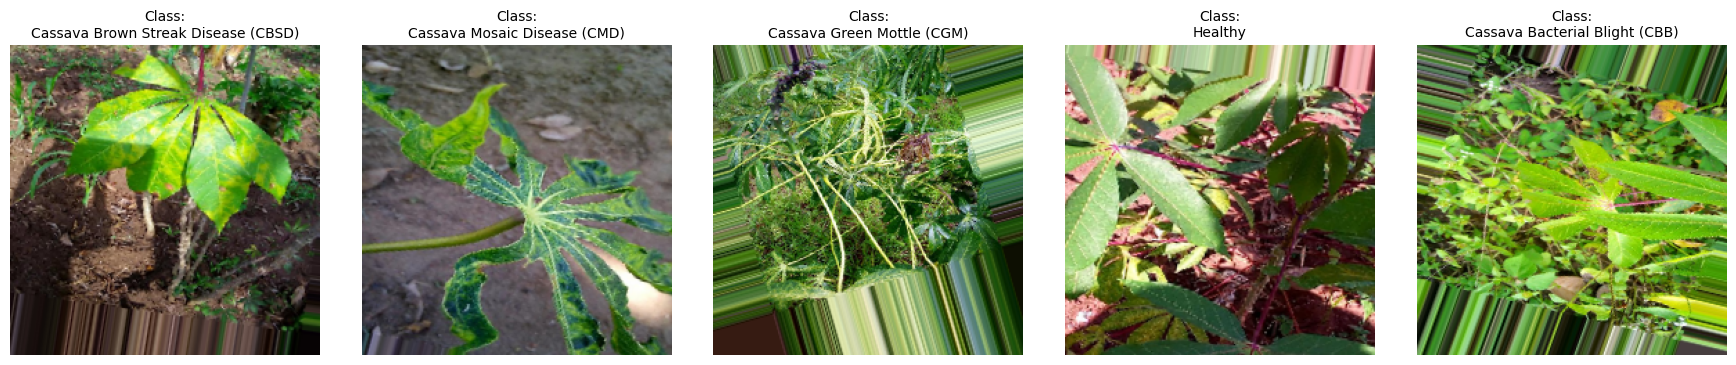

In [ ]:
#VISUALIZATION

class_labels = list(train_generator.class_indices.keys())
num_classes = len(class_labels)

batch_images, batch_labels = next(train_generator)
images_per_class = {}

for image, label in zip(batch_images, batch_labels):
    label_index = np.argmax(label)
    if label_index not in images_per_class:
        images_per_class[label_index] = image
    if len(images_per_class) == num_classes:
        break

# Plot the images
fig, axes = plt.subplots(1, num_classes, figsize=(18, 6))

for idx, (label_index, image) in enumerate(images_per_class.items()):
    ax = axes[idx]
    ax.imshow((image * 255).astype(np.uint8))
    ax.set_title(f"Class:\n{class_labels[label_index]}", fontsize=10)
    ax.axis('off')

plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
#MODEL DEFINITION

# Hybrid Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:-30]:
    layer.trainable = False

cnn_input = base_model.input
cnn_x = base_model.output
cnn_x = GlobalAveragePooling2D()(cnn_x)
cnn_x = Dense(512, activation='relu')(cnn_x)
cnn_x = Dropout(0.3)(cnn_x)

fnn_input = Input(shape=(6,))  # Six fuzzy features
fnn_x = Dense(16, activation='relu')(fnn_input)
fnn_x = Dropout(0.3)(fnn_x)
fnn_x = Dense(8, activation='relu')(fnn_x)

combined = Concatenate()([cnn_x, fnn_x])
final_output = Dense(128, activation='relu')(combined)
final_output = Dropout(0.3)(final_output)
final_output = Dense(5, activation='softmax')(final_output)  # Five classes

hybrid_model = Model(inputs=[cnn_input, fnn_input], outputs=final_output)

hybrid_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

hybrid_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [ ]:
#PARAMETER TUNING

# Define file paths
best_model_path = 'C:/Users/ksaks/Documents/Masters Stuff/Fuzzy Systems/Cassava_Plant_Diseases/best_model_fuzzy_system.h5'
final_model_path = 'C:/Users/ksaks/Documents/Masters Stuff/Fuzzy Systems/Cassava_Plant_Diseases/final_model_fuzzy_system.h5'
best_weights_path = 'C:/Users/ksaks/Documents/Masters Stuff/Fuzzy Systems/Cassava_Plant_Diseases/best_weights_fuzzy_system.h5'

# Callbacks for saving models and monitoring training
model_checkpoint = ModelCheckpoint(
    filepath=best_model_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=50,
    restore_best_weights=True,
    verbose=1
)

# Compute class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Hybrid Data Generators
train_hybrid_generator = hybrid_data_generator(train_generator)
validation_hybrid_generator = hybrid_data_generator(validation_generator)

In [ ]:
#MODEL EXECUTION

# Train the model
history = hybrid_model.fit(
    train_hybrid_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_hybrid_generator,
    validation_steps=len(validation_generator),
    class_weight=class_weights,
    callbacks=[model_checkpoint, early_stopping]
)

hybrid_model.save(final_model_path)

hybrid_model.save_weights(best_weights_path)

Epoch 1/100
535/535 [==============================] - ETA: 0s - loss: 1.2819 - accuracy: 0.5186
Epoch 1: val_accuracy improved from -inf to 0.65965, saving model to C:/Users/ksaks/Documents/Masters Stuff/Fuzzy Systems/Cassava_Plant_Diseases\best_model_fuzzy_system.h5


C:\Users\ksaks\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


535/535 [==============================] - 321s 593ms/step - loss: 1.2819 - accuracy: 0.5186 - val_loss: 0.8973 - val_accuracy: 0.6596
Epoch 2/100
535/535 [==============================] - ETA: 0s - loss: 1.0747 - accuracy: 0.6153
Epoch 2: val_accuracy improved from 0.65965 to 0.66842, saving model to C:/Users/ksaks/Documents/Masters Stuff/Fuzzy Systems/Cassava_Plant_Diseases\best_model_fuzzy_system.h5
535/535 [==============================] - 301s 563ms/step - loss: 1.0747 - accuracy: 0.6153 - val_loss: 1.0113 - val_accuracy: 0.6684
Epoch 3/100
535/535 [==============================] - ETA: 0s - loss: 0.9879 - accuracy: 0.6515
Epoch 3: val_accuracy improved from 0.66842 to 0.76462, saving model to C:/Users/ksaks/Documents/Masters Stuff/Fuzzy Systems/Cassava_Plant_Diseases\best_model_fuzzy_system.h5
535/535 [==============================] - 302s 565ms/step - loss: 0.9879 - accuracy: 0.6515 - val_loss: 0.6818 - val_accuracy: 0.7646
Epoch 4/100
535/535 [==============================

C:\Users\ksaks\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


535/535 [==============================] - 315s 589ms/step - loss: 0.6443 - accuracy: 0.7620 - val_loss: 0.5690 - val_accuracy: 0.8053
Epoch 15/100
535/535 [==============================] - ETA: 0s - loss: 0.6396 - accuracy: 0.7675
Epoch 15: val_accuracy did not improve from 0.80526
535/535 [==============================] - 298s 557ms/step - loss: 0.6396 - accuracy: 0.7675 - val_loss: 0.6875 - val_accuracy: 0.7836
Epoch 16/100
535/535 [==============================] - ETA: 0s - loss: 0.6053 - accuracy: 0.7798
Epoch 16: val_accuracy did not improve from 0.80526
535/535 [==============================] - 296s 553ms/step - loss: 0.6053 - accuracy: 0.7798 - val_loss: 0.8334 - val_accuracy: 0.7456
Epoch 17/100
535/535 [==============================] - ETA: 0s - loss: 0.5919 - accuracy: 0.7827
Epoch 17: val_accuracy did not improve from 0.80526
535/535 [==============================] - 296s 553ms/step - loss: 0.5919 - accuracy: 0.7827 - val_loss: 0.6764 - val_accuracy: 0.7693
Epoch 18/1

535/535 [==============================] - 300s 561ms/step - loss: 0.3289 - accuracy: 0.8554 - val_loss: 0.8745 - val_accuracy: 0.7143
Epoch 43/100
535/535 [==============================] - ETA: 0s - loss: 0.3129 - accuracy: 0.8613
Epoch 43: val_accuracy did not improve from 0.82632
535/535 [==============================] - 306s 572ms/step - loss: 0.3129 - accuracy: 0.8613 - val_loss: 0.4892 - val_accuracy: 0.8143
Epoch 44/100
535/535 [==============================] - ETA: 0s - loss: 0.3241 - accuracy: 0.8570
Epoch 44: val_accuracy did not improve from 0.82632
535/535 [==============================] - 299s 559ms/step - loss: 0.3241 - accuracy: 0.8570 - val_loss: 0.8219 - val_accuracy: 0.7076
Epoch 45/100
535/535 [==============================] - ETA: 0s - loss: 0.3193 - accuracy: 0.8602
Epoch 45: val_accuracy did not improve from 0.82632
535/535 [==============================] - 301s 564ms/step - loss: 0.3193 - accuracy: 0.8602 - val_loss: 0.7119 - val_accuracy: 0.7678
Epoch 46/1

Epoch 70/100
535/535 [==============================] - ETA: 0s - loss: 0.2314 - accuracy: 0.8925
Epoch 70: val_accuracy did not improve from 0.85322
535/535 [==============================] - 297s 556ms/step - loss: 0.2314 - accuracy: 0.8925 - val_loss: 0.4742 - val_accuracy: 0.8506
Epoch 71/100
535/535 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.9002
Epoch 71: val_accuracy improved from 0.85322 to 0.85731, saving model to C:/Users/ksaks/Documents/Masters Stuff/Fuzzy Systems/Cassava_Plant_Diseases\best_model_fuzzy_system.h5
535/535 [==============================] - 296s 554ms/step - loss: 0.2139 - accuracy: 0.9002 - val_loss: 0.5362 - val_accuracy: 0.8573
Epoch 72/100
535/535 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.9004
Epoch 72: val_accuracy did not improve from 0.85731
535/535 [==============================] - 295s 552ms/step - loss: 0.2158 - accuracy: 0.9004 - val_loss: 0.5513 - val_accuracy: 0.8310
Epoch 73/100
535/535 

Epoch 98/100
535/535 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.9187
Epoch 98: val_accuracy did not improve from 0.91316
535/535 [==============================] - 317s 594ms/step - loss: 0.1753 - accuracy: 0.9187 - val_loss: 0.4247 - val_accuracy: 0.8640
Epoch 99/100
535/535 [==============================] - ETA: 0s - loss: 0.1725 - accuracy: 0.9164
Epoch 99: val_accuracy did not improve from 0.91316
535/535 [==============================] - 310s 580ms/step - loss: 0.1725 - accuracy: 0.9164 - val_loss: 0.3989 - val_accuracy: 0.8751
Epoch 100/100
535/535 [==============================] - ETA: 0s - loss: 0.1647 - accuracy: 0.9193
Epoch 100: val_accuracy did not improve from 0.91316
535/535 [==============================] - 311s 583ms/step - loss: 0.1647 - accuracy: 0.9193 - val_loss: 0.3918 - val_accuracy: 0.8749


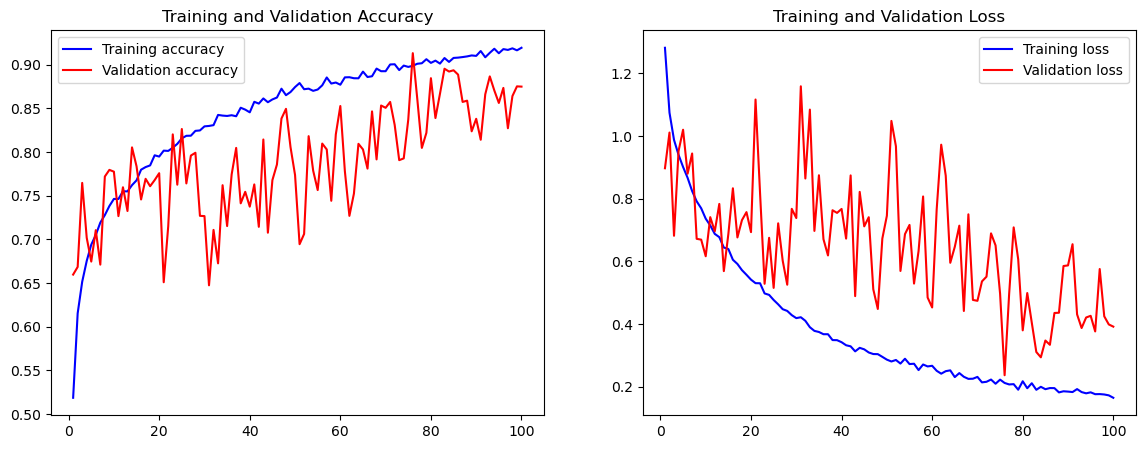

In [ ]:
#PLOTTING

# Plot training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [ ]:
#TESTING

best_model_path = 'C:/Users/ksaks/Documents/Masters Stuff/Fuzzy Systems/Cassava_Plant_Diseases/best_model_fuzzy_system.h5'
best_model = load_model(best_model_path)

def generate_fuzzified_features(image_batch):
    fuzzified_features = []
    for image in image_batch:
        color = np.mean(image)
        texture = np.std(image)
        fuzzy_output = fuzzy_inference(color, texture)
        fuzzified_features.append(fuzzy_output)
    return np.array(fuzzified_features)

image_features = []
true_labels = []

test_generator.reset()

for _ in range(len(test_generator)):
    x_batch, y_batch = next(test_generator)
    image_features.append(x_batch)
    true_labels.extend(np.argmax(y_batch, axis=1))

image_features = np.concatenate(image_features, axis=0)
true_labels = np.array(true_labels)

fuzzified_features = generate_fuzzified_features(image_features)

predictions = best_model.predict([image_features, fuzzified_features], batch_size=32)

y_pred = np.argmax(predictions, axis=1)

class_labels = list(test_generator.class_indices.keys())
print("Classification Report")
print(classification_report(true_labels, y_pred, target_names=class_labels))

cm = confusion_matrix(true_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

MemoryError: Unable to allocate 3.36 GiB for an array with shape (5990, 224, 224, 3) and data type float32

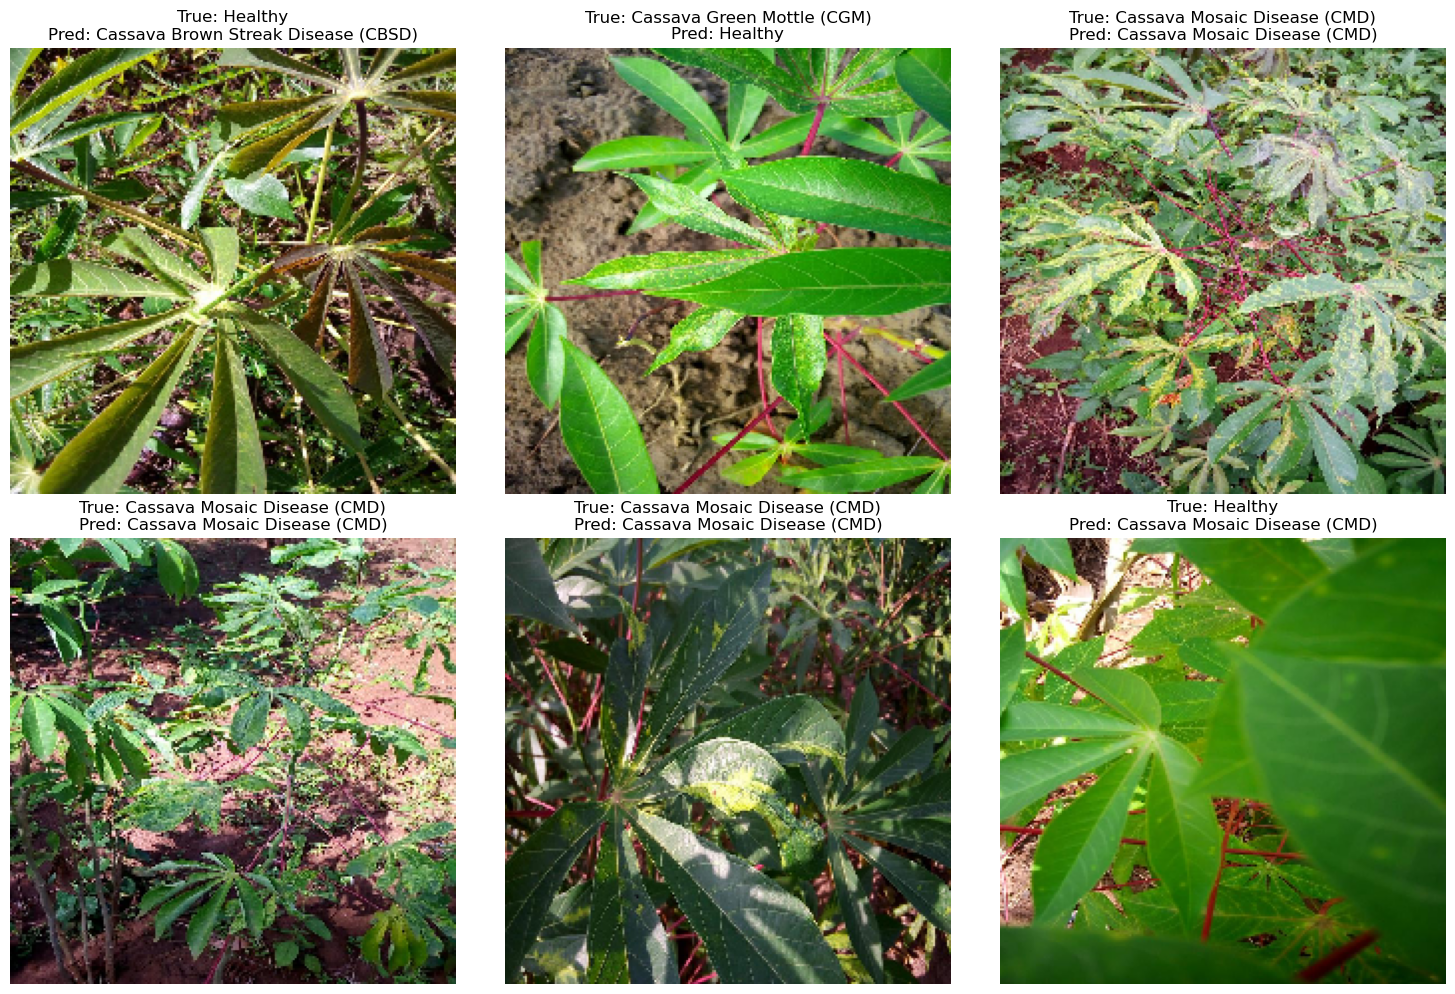

In [ ]:
def show_sample_images_with_predictions(generator, true_labels, predicted_labels, class_labels, num_samples=6):
    fig, axes = plt.subplots(2, num_samples // 2, figsize=(15, 10))
    axes = axes.flatten()
    for img, ax, true_label, pred_label in zip(generator[0][0][:num_samples], axes, true_labels[:num_samples], predicted_labels[:num_samples]):
        img = (img * 255).astype(np.uint8)
        ax.imshow(img)
        ax.set_title(f'True: {class_labels[true_label]}\nPred: {class_labels[pred_label]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images_with_predictions(test_generator, true_labels, y_pred, class_labels)

In [ ]:
#GUI IMPLEMENTATION

import gradio as gr
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# Load the best model
best_model_path = 'C:/Users/ksaks/Documents/Masters Stuff/Fuzzy Systems/Cassava_Plant_Diseases/best_model_fuzzy_system.h5'
best_model = load_model(best_model_path)

# Function to preprocess a single image for Gradio
def preprocess_image(image):
    image = image.resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to generate fuzzified features for a batch of images
def generate_fuzzified_features(image_batch):
    fuzzified_features = []
    for image in image_batch:
        color = np.mean(image)
        texture = np.std(image)
        fuzzy_output = fuzzy_inference(color, texture)
        fuzzified_features.append(fuzzy_output)
    return np.array(fuzzified_features)

# Gradio function to predict class for a single image
def predict(image):
    # Preprocess image
    image = preprocess_image(image)
    
    # Generate fuzzified features
    color = np.mean(image)
    texture = np.std(image)
    fuzzy_output = fuzzy_inference(color, texture)
    fuzzified_test_features = np.expand_dims(fuzzy_output, axis=0)  # Add batch dimension
    
    # Predict using the best model
    prediction = best_model.predict([image, fuzzified_test_features])
    predicted_class = np.argmax(prediction)
    
    # Get class labels
    class_labels = list(test_generator.class_indices.keys())
    return f"Predicted Class: {class_labels[predicted_class]}"

# Function to evaluate the best model on the test set and return results
def evaluate_test_set():
    # Extract images and labels from the test generator
    image_features = []
    true_labels = []

    # Reset the generator
    test_generator.reset()

    for _ in range(len(test_generator)):
        x_batch, y_batch = next(test_generator)
        image_features.append(x_batch)
        true_labels.extend(np.argmax(y_batch, axis=1))  # Convert one-hot to class indices

    # Convert image features and true labels to arrays
    image_features = np.concatenate(image_features, axis=0)
    true_labels = np.array(true_labels)

    # Generate fuzzified features for the test set
    fuzzified_features = generate_fuzzified_features(image_features)

    # Generate predictions using the best model
    predictions = best_model.predict([image_features, fuzzified_features], batch_size=32)

    # Get predicted labels
    y_pred = np.argmax(predictions, axis=1)

    # Classification report
    class_labels = list(test_generator.class_indices.keys())
    report = classification_report(true_labels, y_pred, target_names=class_labels)

    # Confusion matrix
    cm = confusion_matrix(true_labels, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return report

# Create Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Upload an Image"),
    outputs="text",
    title="Hybrid Model for Cassava Plant Diseases",
    description="Upload an image to classify it into one of the Cassava Plant Disease categories."
)

# Launch Gradio interface
interface.launch()

* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 42ms/step
